<a target="_blank" href="https://colab.research.google.com/github/binado/sbisandbox/blob/main/notebooks/mcmc.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Comparison with MCMC

In this notebook, we will compare two parameter estimation methods: SBI and traditional MCMC.

## The model

Our model of choice is a Gaussian mixture, which we describe below:

The parameters $\boldsymbol{\theta} \in \mathbb{R}^n$ are sampled independently from a uniform distribution,

$$ \theta_i \sim \mathcal{U}([-1, 1]),$$

for $i \in \{1, \ldots, n\}$.

The data $\boldsymbol{x} \in \mathbb{R}^n$ are generated as follows:

$$ \boldsymbol{x} \sim 0.5 \mathcal{N}(\mu=\boldsymbol{\theta}, \sigma_1 \boldsymbol{I}_n) + 0.5 \mathcal{N}(\mu=\boldsymbol{\theta}, \sigma_2 \boldsymbol{I}_n),$$

where $\sigma_1 \gg \sigma_2 > 0$. We fix $\sigma_1 = 1, \sigma_2 = 0.01$.

In [1]:
%load_ext autoreload
%autoreload 2
import sys

sys.path.append("..")

import torch
import matplotlib.pyplot as plt
import arviz as az
from sbi import analysis as analysis
from sbi import utils as utils

from sbisandbox.benchmarks import GaussianMixtureBenchmark
from sbisandbox.runners import SNPERunner, MCMCRunner

%matplotlib
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-whitegrid")

/Users/bernardoveronese/miniconda3/envs/sbibench/lib/python3.10/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


Using matplotlib backend: module://matplotlib_inline.backend_inline


In [2]:
ndim = 2
benchmark = GaussianMixtureBenchmark(ndim)

In [3]:
num_simulations = 1000
seed = 1991
theta, x = benchmark.get_observations(
    num_simulations, seed=seed, simulation_batch_size=None
)

Plotting histograms:

[Text(0.5, 0, '$x_1$'), Text(0, 0.5, '$x_2$')]

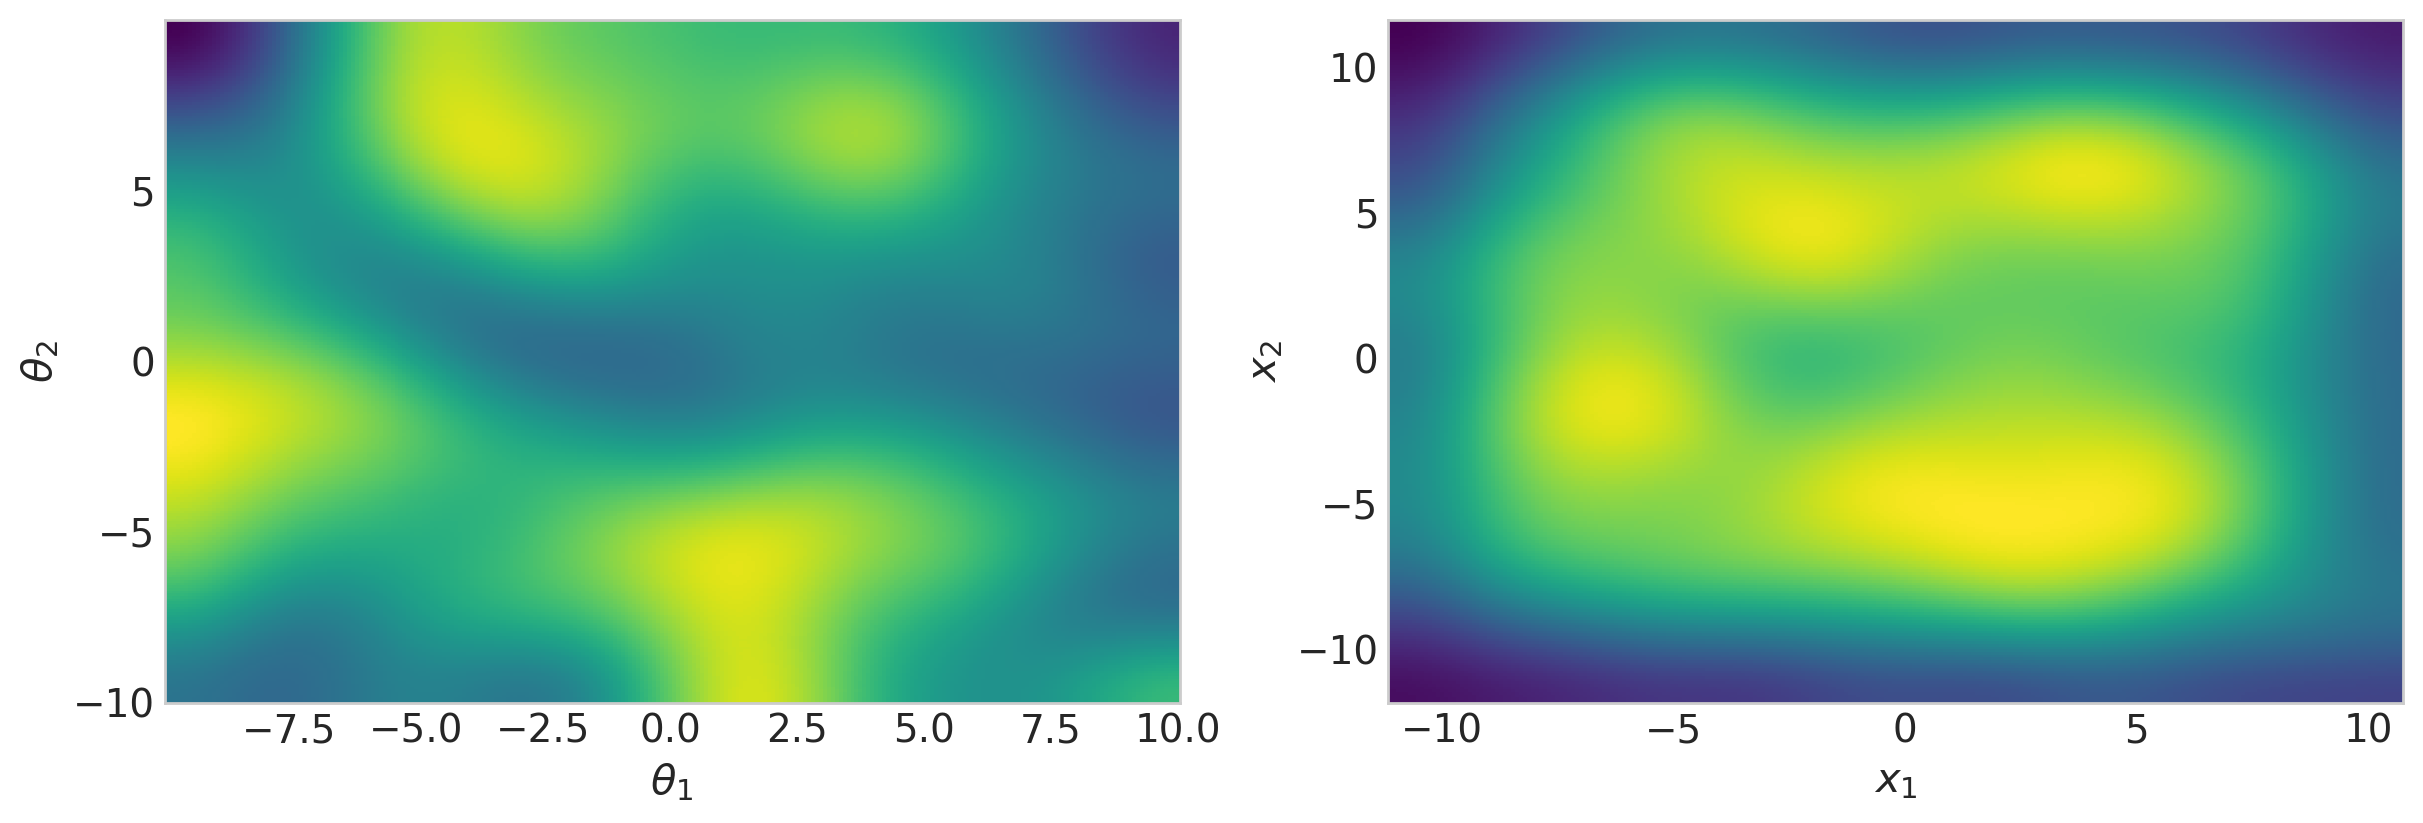

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

theta_labels = [r"$\theta_1$", r"$\theta_2$"]
x_labels = ["$x_1$", "$x_2$"]

az.plot_kde(theta[:, 0], theta[:, 1], contour=False, ax=ax1)
ax1.set(xlabel=theta_labels[0], ylabel=theta_labels[1])

az.plot_kde(x[:, 0], x[:, 1], contour=False, ax=ax2)
ax2.set(xlabel=x_labels[0], ylabel=x_labels[1])

Choosing fiducial values:

In [5]:
fiducial_theta = torch.zeros(ndim)
num_samples = 10000
num_simulations = 10000
x0 = benchmark.simulator(fiducial_theta.unsqueeze(0))

## Reference posterior samples

We can sample from the analytical posterior in a straightforward manner:

1. Sample $u \sim \text{Bernoulli}(p=0.5)$
2. If $u=1$, choose $\sigma=\sigma_1$, else choose $\sigma=\sigma_2$
3. Sample $\boldsymbol{x} \sim \mathcal{N}(\boldsymbol{\theta}, \sigma I_n)$

In [6]:
true_samples = benchmark.get_posterior_samples((1, num_samples), x=x0)

array([[<Axes: >, None],
       [<Axes: xlabel='$\\theta_1$', ylabel='$\\theta_2$'>, <Axes: >]],
      dtype=object)

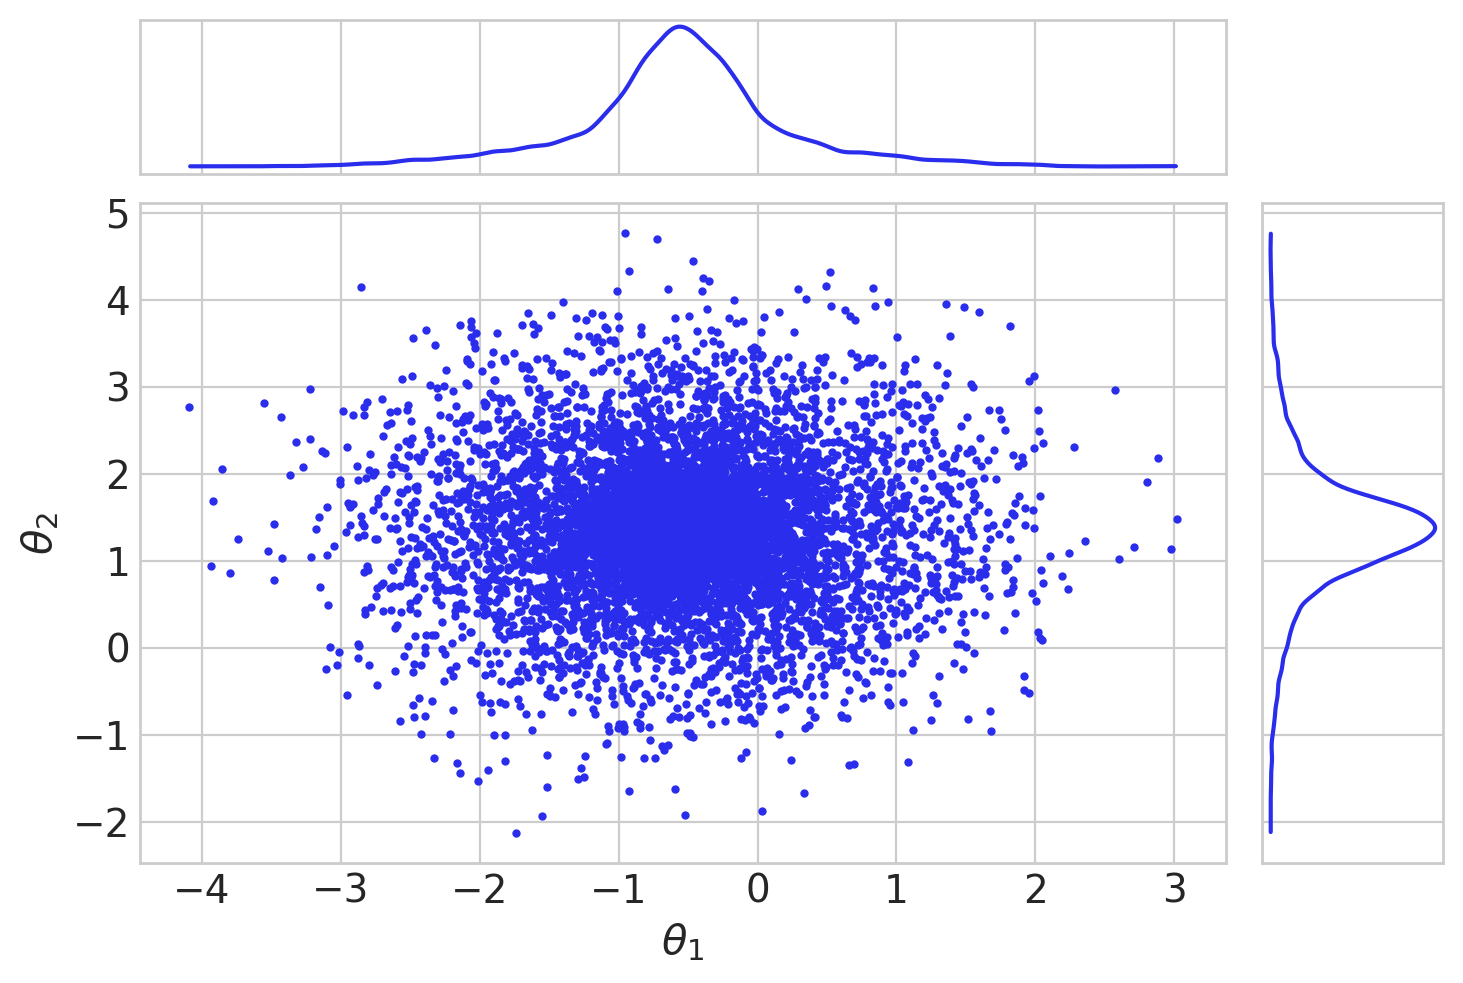

In [7]:
def get_data(labels, samples, warmup: int = 0, thin: int = 1):
    data = (samples[warmup::thin, :, 0], samples[warmup::thin, :, 1])
    return dict(zip(labels, data))


data_from_true_posterior = get_data(theta_labels, true_samples)

az.plot_pair(data_from_true_posterior, var_names=theta_labels, marginals=True)

We indeed see two populations of samples with different variance. Let us see the data generated from the posterior samples as a sanity check:

<Axes: >

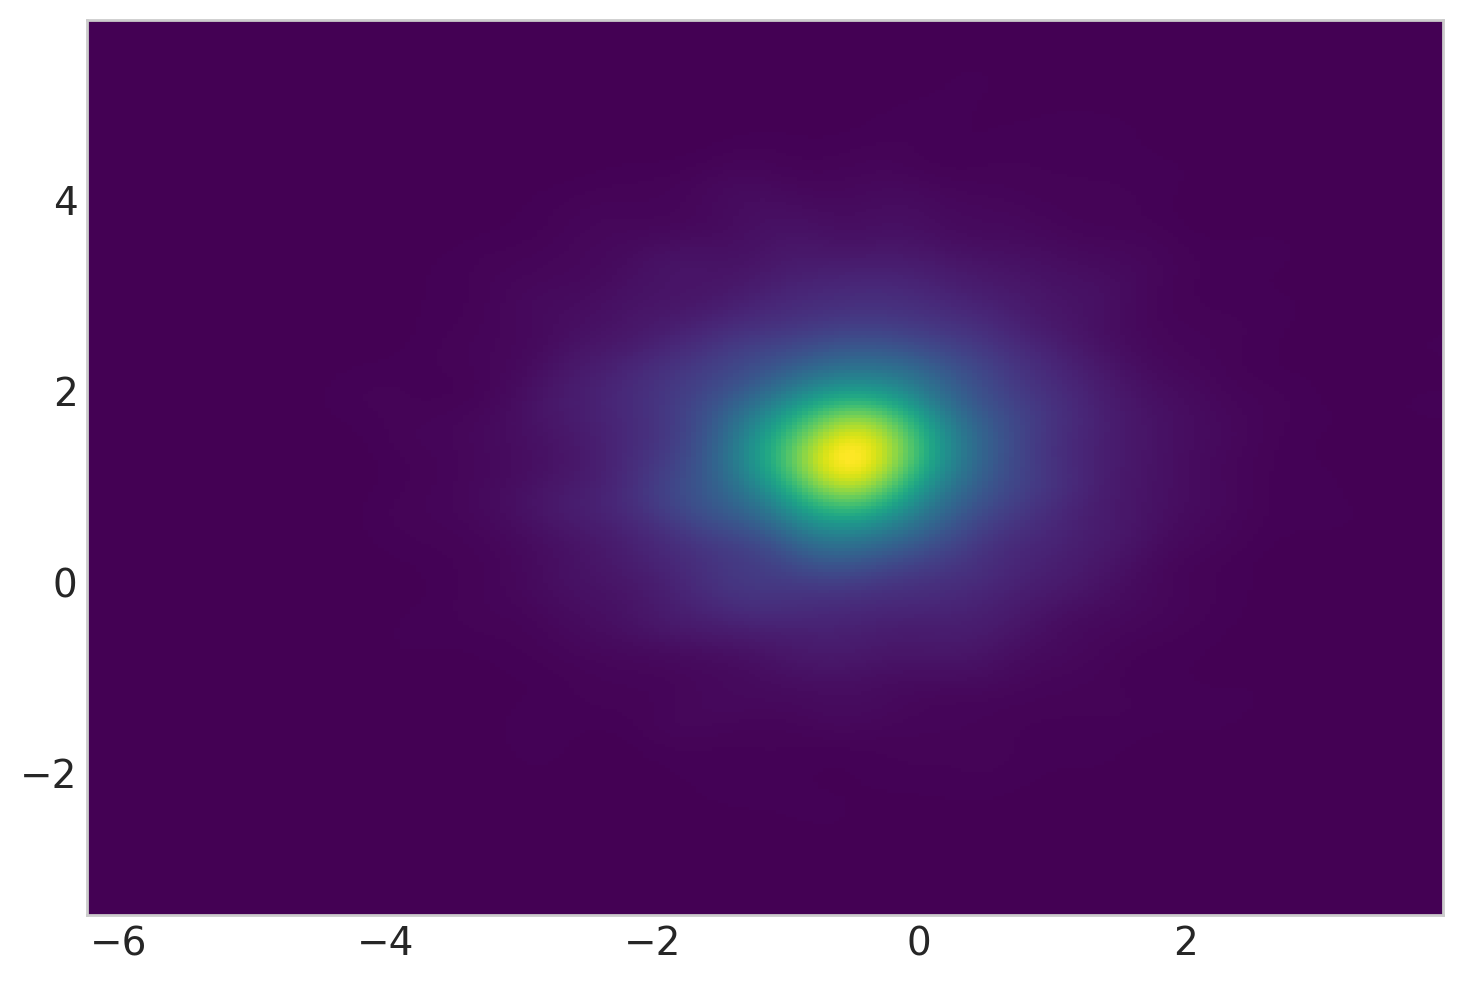

In [8]:
x_from_posterior_samples = benchmark.simulator(true_samples.squeeze())
az.plot_kde(
    x_from_posterior_samples[:, 0], x_from_posterior_samples[:, 1], contour=False
)

## MCMC

We run MCMC with pyro's implementation of the NUTS sampler, which gets called under the hood from the `MCMCRunner` class:

In [9]:
%%time

# Warmup will take num_samples / 2 steps as well
mcmc = MCMCRunner(benchmark=benchmark, seed=seed)
mcmc_samples = mcmc.sample(num_samples // 2, x=x0)

Sample: 100%|██████████████████████████████████████| 10000/10000 [03:24, 48.97it/s, step size=8.38e-01, acc. prob=0.922]                                                                       

CPU times: user 5min 30s, sys: 6.87 s, total: 5min 37s
Wall time: 3min 24s


In [10]:
mcmc_samples["theta"].shape

torch.Size([5000, 1, 2])

Visualizing the results in a corner plot:

/Users/bernardoveronese/miniconda3/envs/sbibench/lib/python3.10/site-packages/arviz/data/base.py:265: UserWarning: More chains (5000) than draws (1). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


array([[<Axes: >, None],
       [<Axes: xlabel='$\\theta_1$', ylabel='$\\theta_2$'>, <Axes: >]],
      dtype=object)

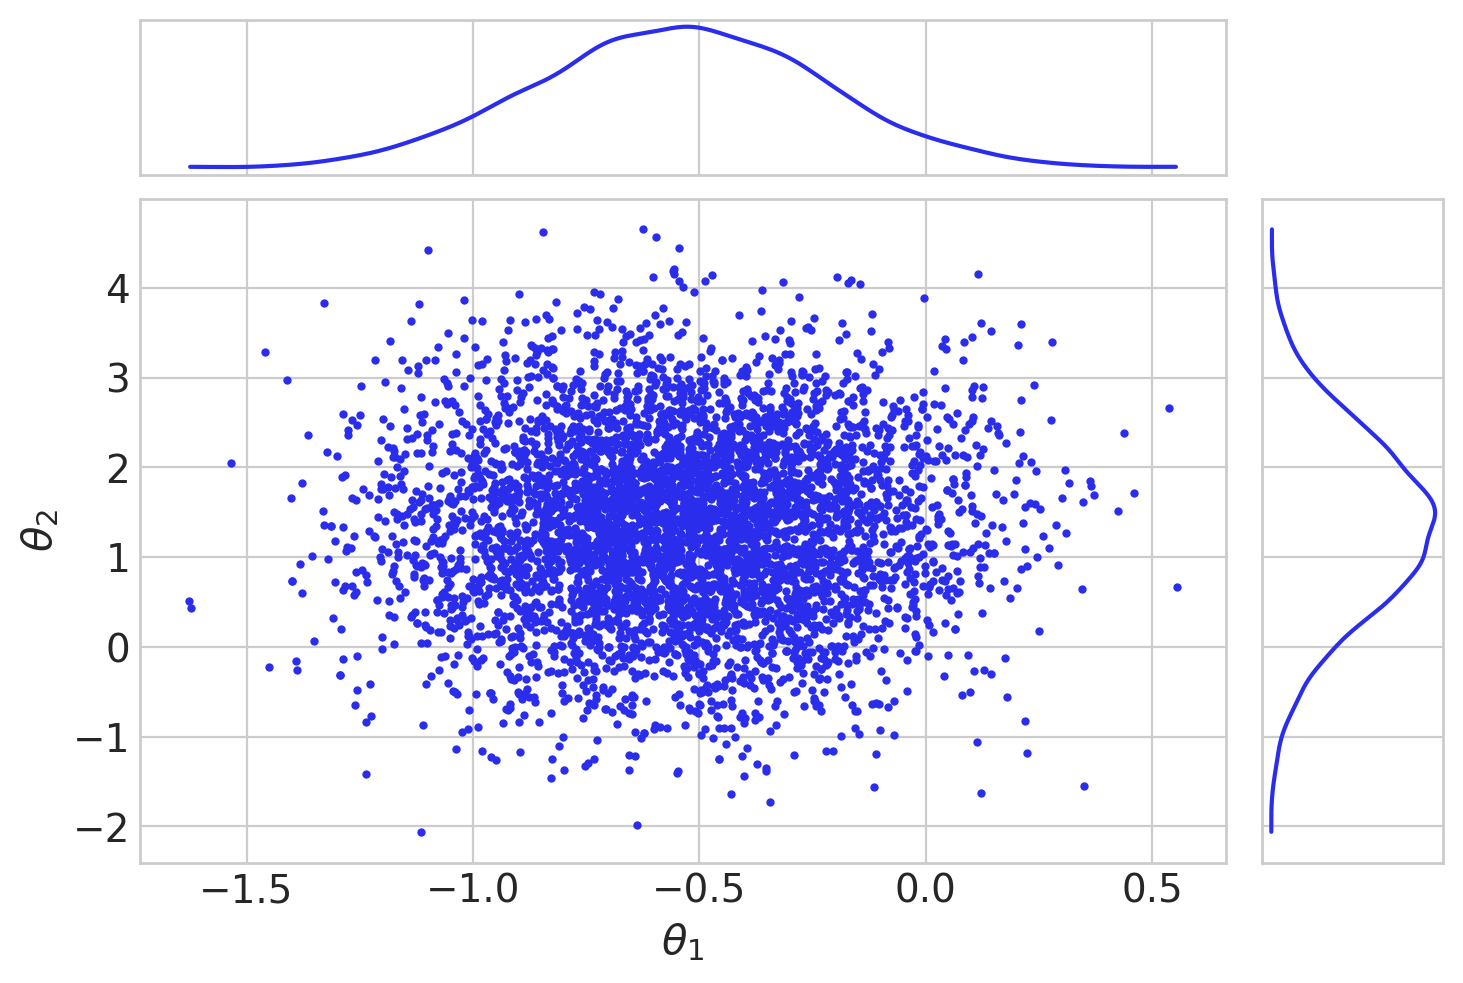

In [11]:
data_from_mcmc = get_data(theta_labels, mcmc_samples["theta"])
az.plot_pair(data_from_mcmc, var_names=theta_labels, marginals=True)

We observe that the chains do not seem to explore the whole posterior mass along the first dimension $\theta_1$. Perhaps we need more samples?

## NPE

We choose NPE as the SBI counterpart so as to avoid running a complementary MCMC step. We use neural spline flows as they seem to have the best performance on this task.

In [12]:
npe = SNPERunner(benchmark=benchmark, seed=seed, density_estimator="nsf")

In [13]:
num_simulations = 10000
training_kwargs = {
    "show_train_summary": True,
    "training_batch_size": 128,
    "use_combined_loss": True,
    "learning_rate": 2e-4,
}
truncate_at = 1e-3

In [14]:
%%time

npe.train(
    num_simulations, x_0=x0, training_kwargs=training_kwargs, truncate_at=truncate_at
)

samples_from_npe = npe.sample(num_samples, x=x0)

Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

 Neural network successfully converged after 58 epochs.
        -------------------------
        ||||| ROUND 1 STATS |||||:
        -------------------------
        Epochs trained: 58
        Best validation performance: -1.9371
        -------------------------
        


Drawing 1000000 posterior samples:   0%|          | 0/1000000 [00:00<?, ?it/s]

/Users/bernardoveronese/miniconda3/envs/sbibench/lib/python3.10/site-packages/nflows/transforms/lu.py:80: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:2198.)
  outputs, _ = torch.triangular_solve(


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

CPU times: user 6min 40s, sys: 24.9 s, total: 7min 5s
Wall time: 3min 47s


array([[<Axes: >, None],
       [<Axes: xlabel='$\\theta_1$', ylabel='$\\theta_2$'>, <Axes: >]],
      dtype=object)

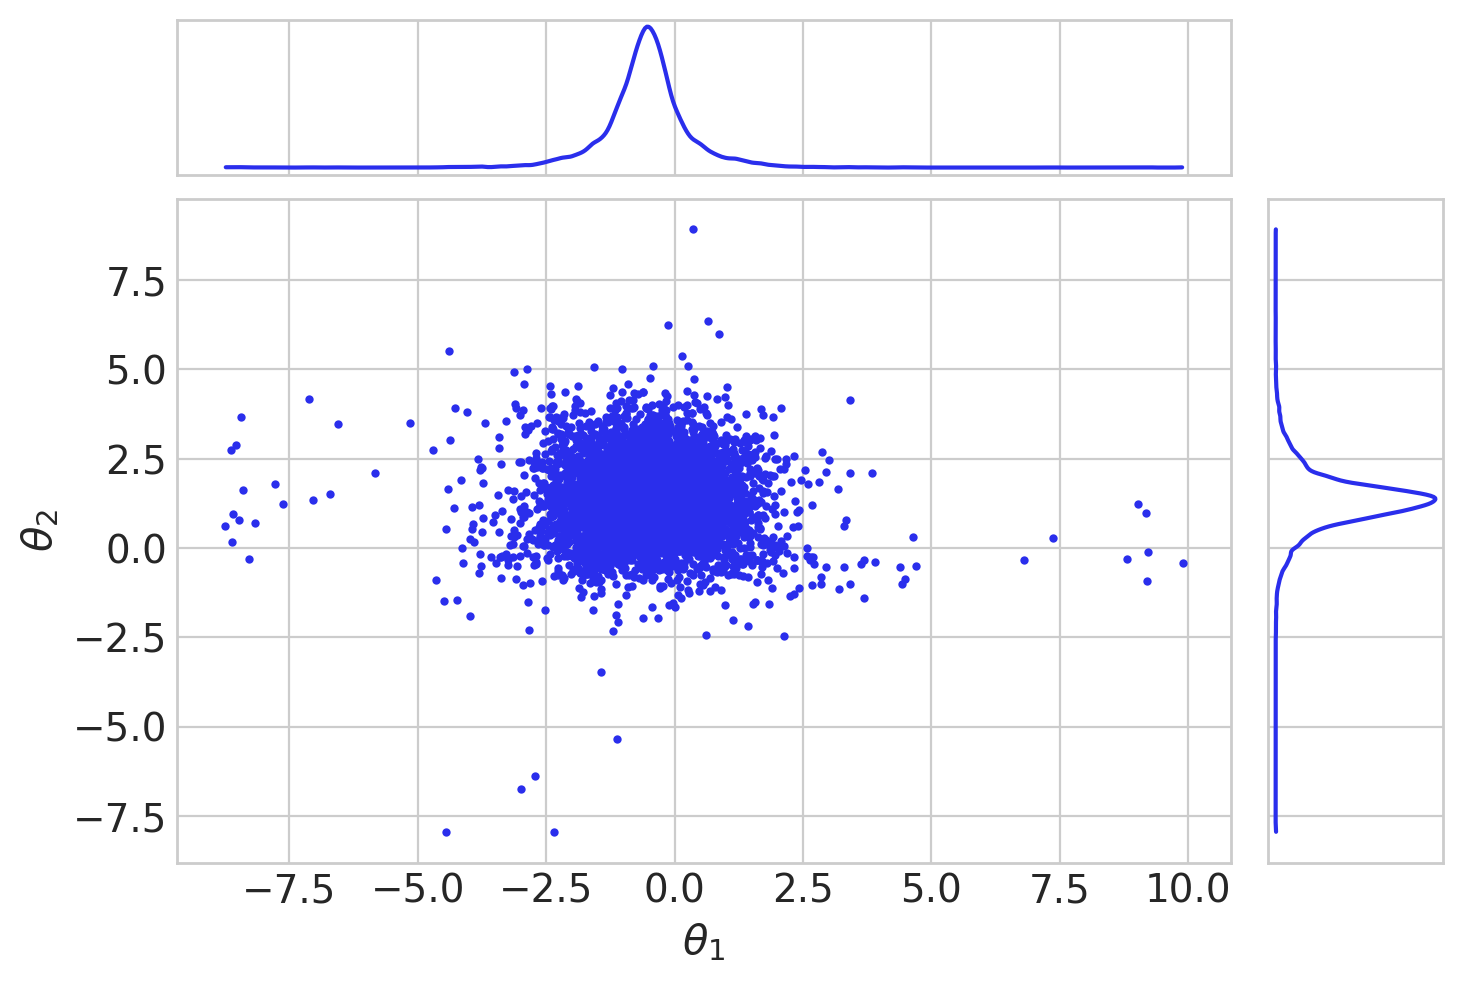

In [15]:
data_from_npe = get_data(theta_labels, samples_from_npe.unsqueeze(0))
az.plot_pair(data_from_npe, var_names=theta_labels, marginals=True)

We do see some posterior leakage, but it does not seem to be significant with respect to the total number of samples.

## Comparing results

Visualizing marginals:

array([[<Axes: title={'center': '$\\theta_1$'}>,
        <Axes: title={'center': '$\\theta_2$'}>]], dtype=object)

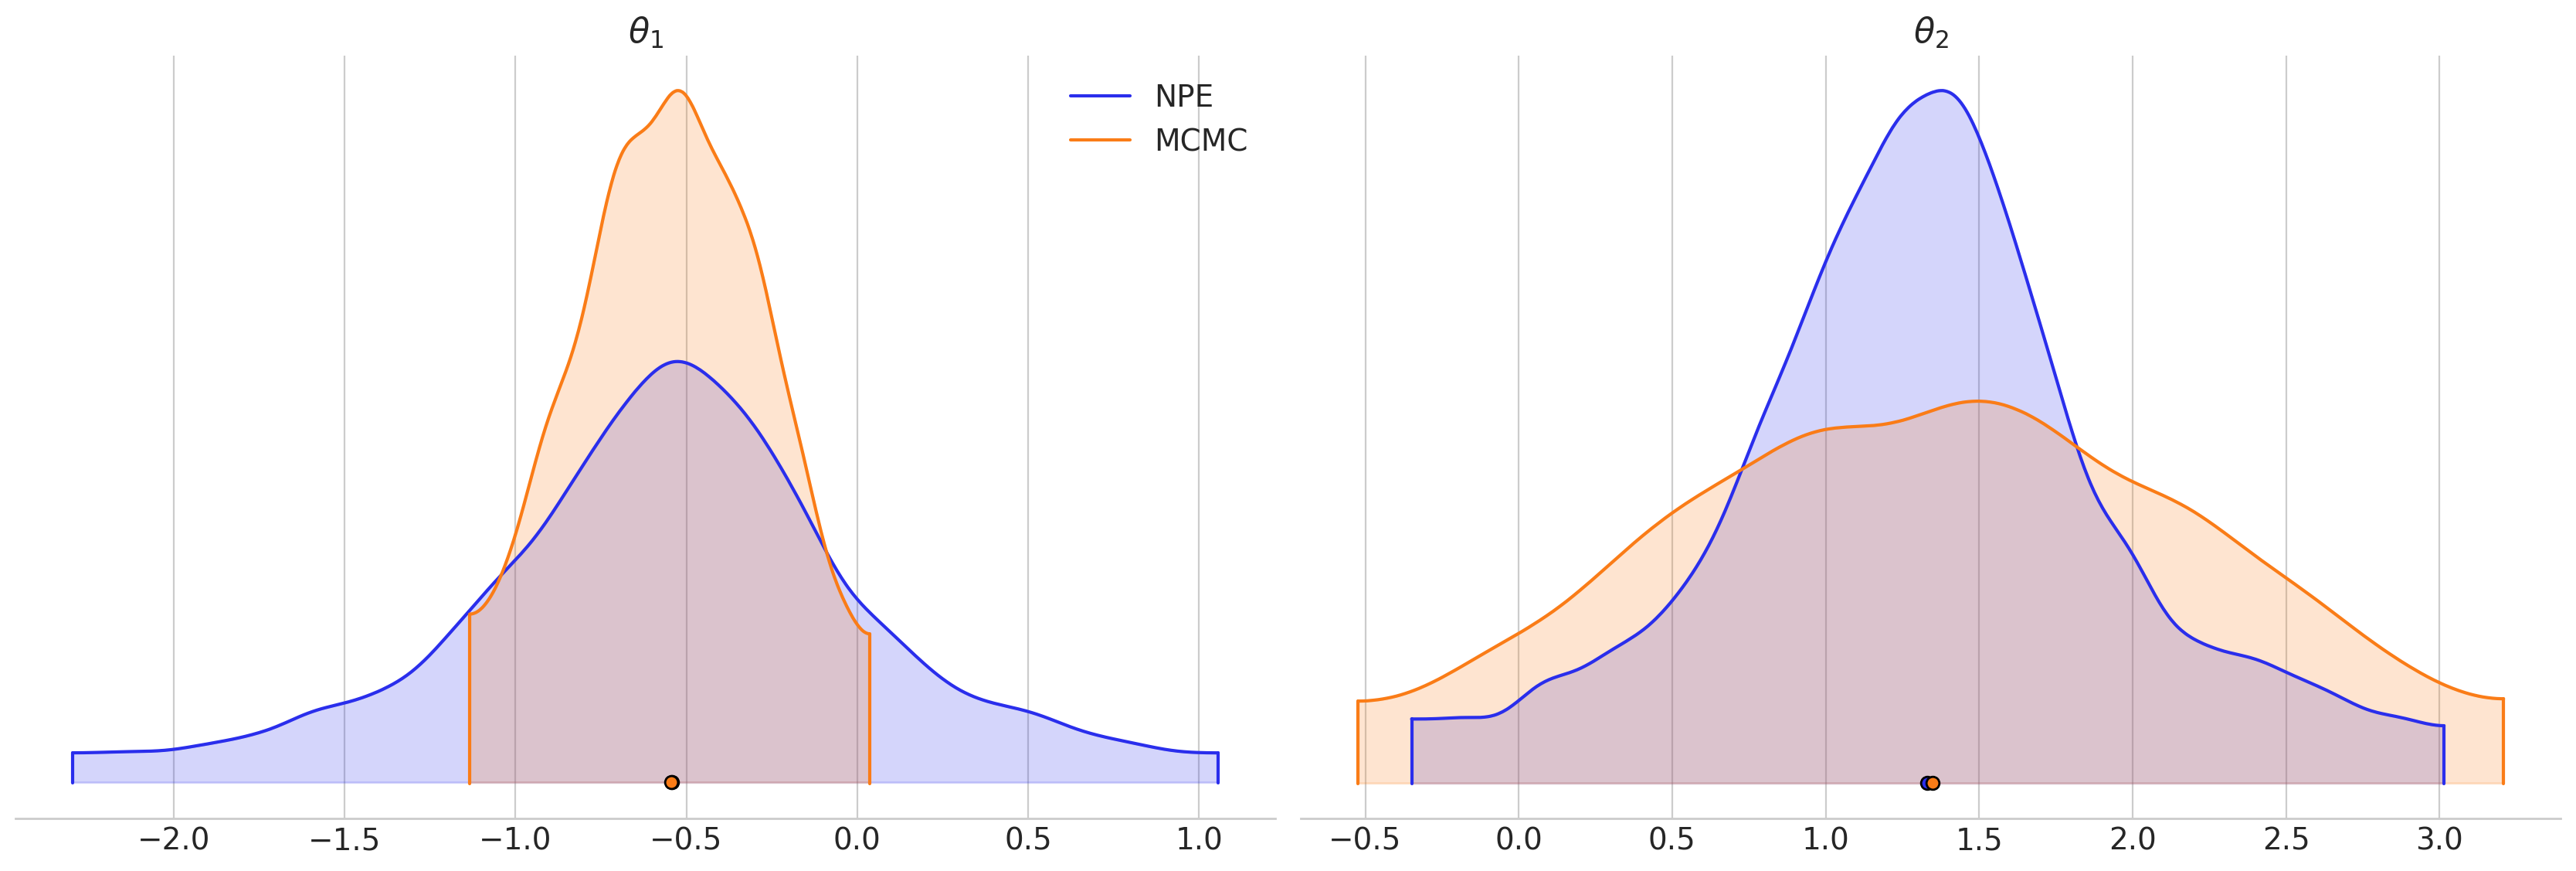

In [16]:
az.plot_density(
    [data_from_npe, data_from_mcmc],
    data_labels=["NPE", "MCMC"],
    var_names=theta_labels,
    shade=0.2,
)

array([[<Axes: title={'center': '$\\theta_1$'}>,
        <Axes: title={'center': '$\\theta_2$'}>]], dtype=object)

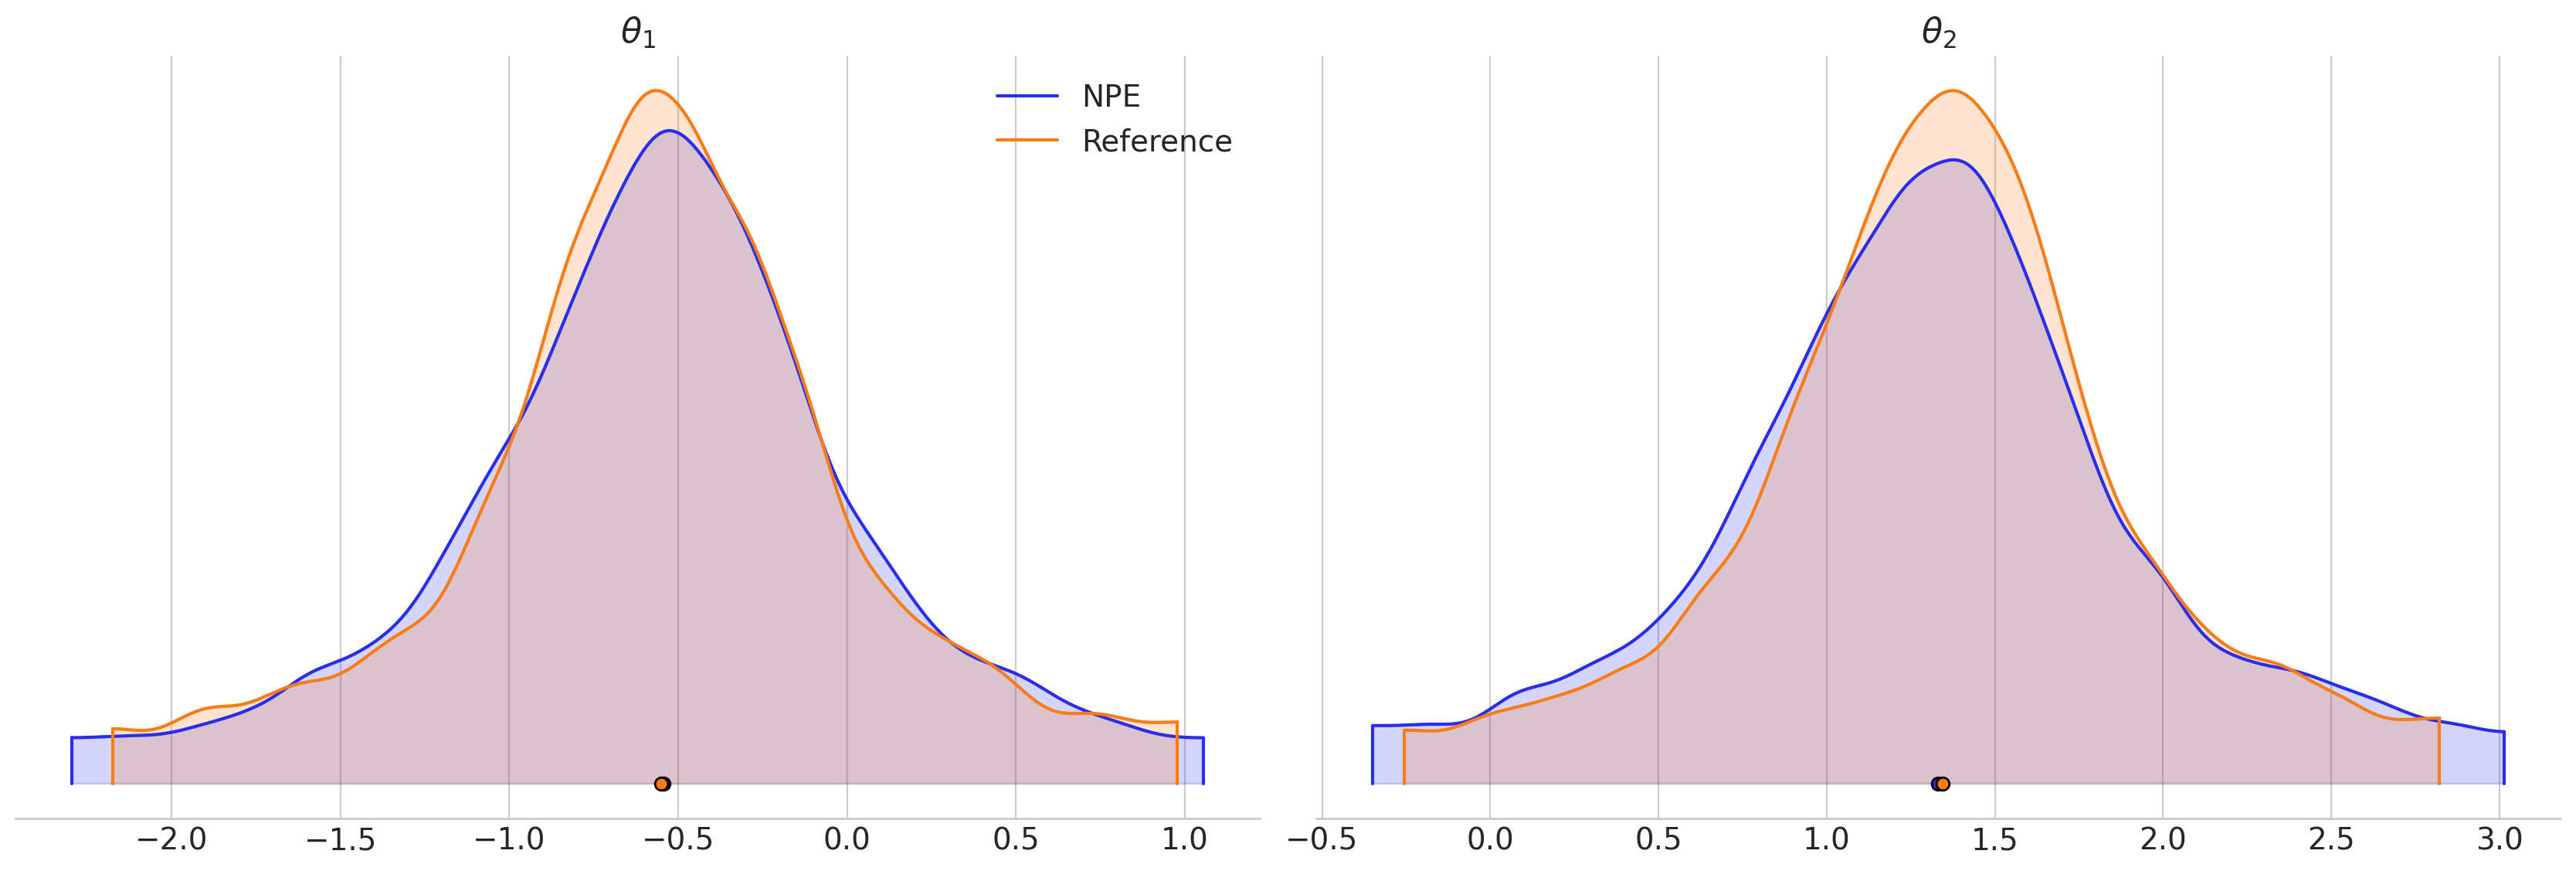

In [17]:
az.plot_density(
    [data_from_npe, data_from_true_posterior],
    data_labels=["NPE", "Reference"],
    var_names=theta_labels,
    shade=0.2,
)

array([[<Axes: title={'center': '$\\theta_1$'}>,
        <Axes: title={'center': '$\\theta_2$'}>]], dtype=object)

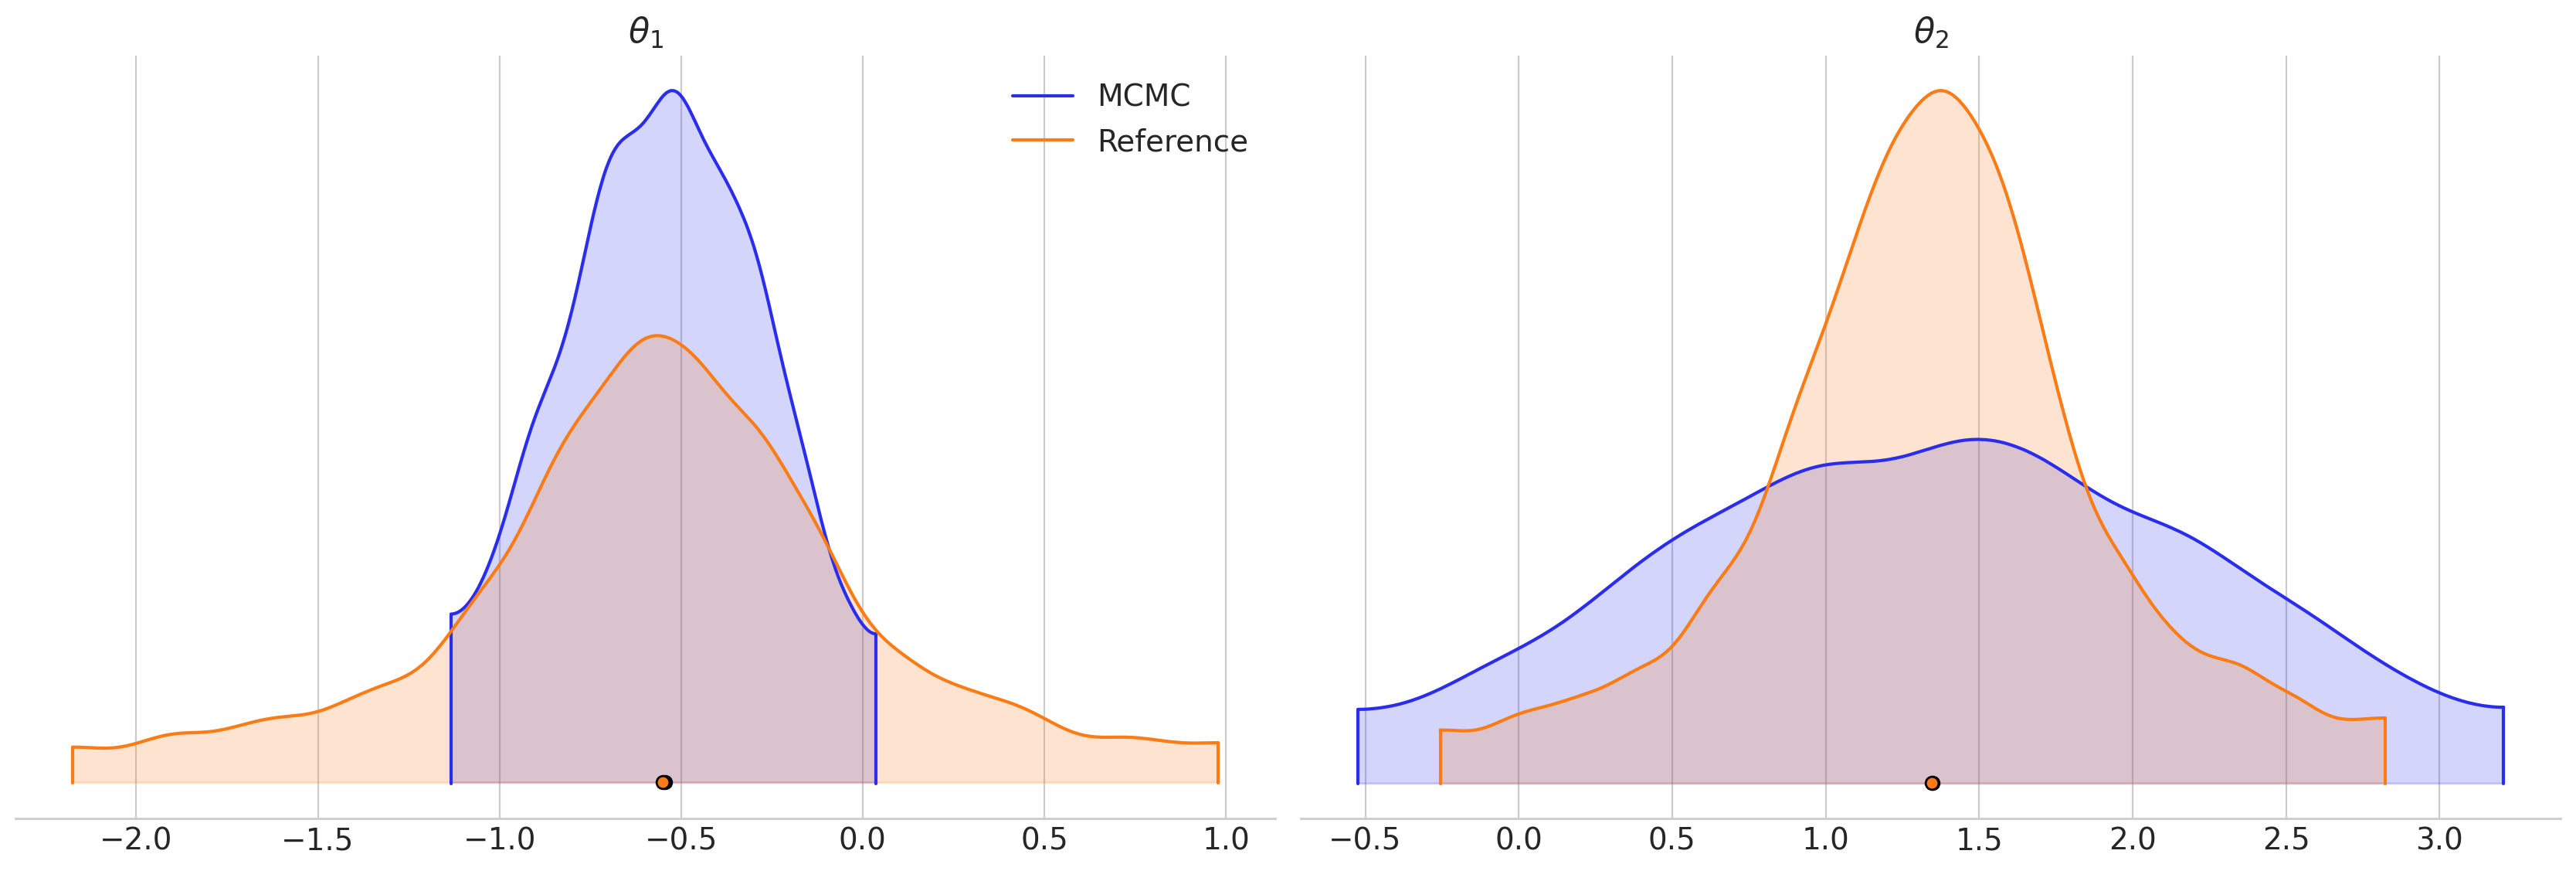

In [18]:
az.plot_density(
    [data_from_mcmc, data_from_true_posterior],
    data_labels=["MCMC", "Reference"],
    var_names=theta_labels,
    shade=0.2,
)